# Classification de radiographies pulmonaires à l'aide de réseaux de neurone convolutifs.
**Gilbert Jabbour et Fayçal Zine-Eddine**

Le but de ce projet est de classifier des radiographies pulmonaires à l'aide d'apprentissage profond.

Nous nous sommes intéressés plus particulièrement à la détection de pneumonie et d'oedème pulmonaire, car c'est des conditions vues fréquemment en clinique, qu'on veut généralement traiter rapidement et qui sont régulièrement confondues. 

Ce *notebook* détaille la visualisation des données, la transformation et l'extraction des caractéristiques pertinentes et la production des jeux de données qui seront utilisées par notre algorithme.

Nous avons choisi de présenter ce notebook directement sur Kaggle, pour éviter de devoir télécharger la large base de données du NIH pour laquelle nous allons seulement utiliser une fraction des images.

Le reste du code est accessible sur Github : https://github.com/Fay-Zine/NIH-Chest-XRay

# Import and data loading

In [1]:
import os
from glob import glob
import io
from itertools import chain
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import pyarrow as pa
import pyarrow.parquet as pq
import warnings
import copy
warnings.filterwarnings("ignore", category=FutureWarning)

### Load dataset and visualize classes
DATA_FILE_PATH = "../input/data/Data_Entry_2017.csv"
BASE_IMAGE_DIR = "/kaggle/input/data"

full_df = pd.read_csv(DATA_FILE_PATH)
full_df = full_df[full_df['Patient Age'] <= 100]  #Présence d'outliers lors de la visualisation du df
full_df.describe()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,0.0
mean,8.574172,14345.720724,46.872574,2646.035253,2486.393153,0.155651,0.155651,NaN
std,15.406734,8403.980520,16.598152,341.243771,401.270806,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7308.000000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,95.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


# Data visualization

## Classes distribution
On observe qu'il y a un débalancement majeur entre les classes. 
Pour nos maladies d'intérêt, il y a environ 4000  images sur les 120 000 disponibles dans le dataset.

No Finding            60353
Infiltration          19891
Effusion              13316
Atelectasis           11558
Nodule                 6331
Mass                   5779
Pneumothorax           5301
Consolidation          4667
Pleural_Thickening     3384
Cardiomegaly           2776
Emphysema              2516
Edema                  2302
Fibrosis               1686
Pneumonia              1430
Hernia                  227
Name: count, dtype: int64


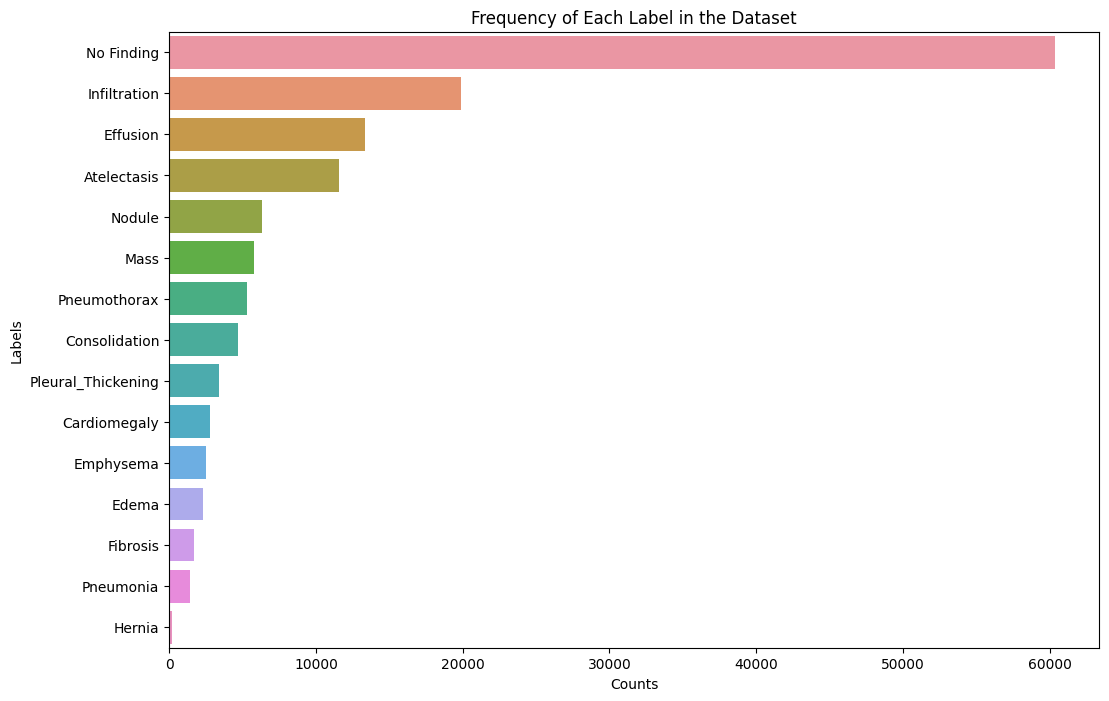

In [2]:
all_labels = np.unique(list(chain(*full_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]

for c_label in all_labels:
    if len(c_label) > 0:
        full_df[c_label] = full_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

label_counts = (
    full_df["Finding Labels"].str.split("|", expand=True).stack().value_counts()
)
print(label_counts)
label_columns = [label for label in all_labels if label in full_df.columns]
label_df = full_df[label_columns]

correlation_matrix = label_df.corr()

# Overall Label Counts
plt.figure(figsize=(12, 8))
sns.barplot(y=label_counts.index, x=label_counts.values)
plt.title("Frequency of Each Label in the Dataset")
plt.xlabel("Counts")
plt.ylabel("Labels")
plt.show()

## Classes correlations
Étant donné que plusieurs "label" comme la cardiomégalie ou l'épanchement peuvent être associé à de l'insuffisance cardiaque, nous avons exploré l'interdépendance des maladies pour voir si des classes étaient fortement liées et pouvaient être utilisées pour améliorer notre modèle.

Aucun des coefficients n'était particulièrement haut, le plus grand étant la combinaison des deux maladies d'intérêt. Les probabilités conditionnelles variaient, mais les inclure aurait grandement augmenté la complexité du modèle avec un gain qu'on suspecte limité sur les performances.

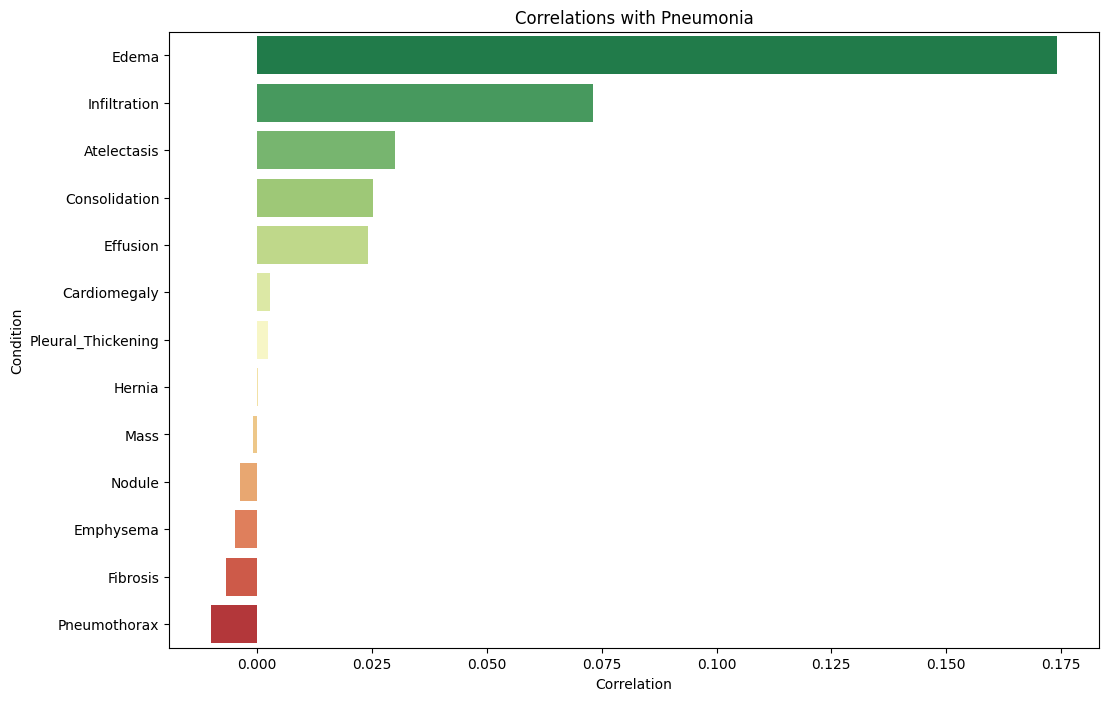

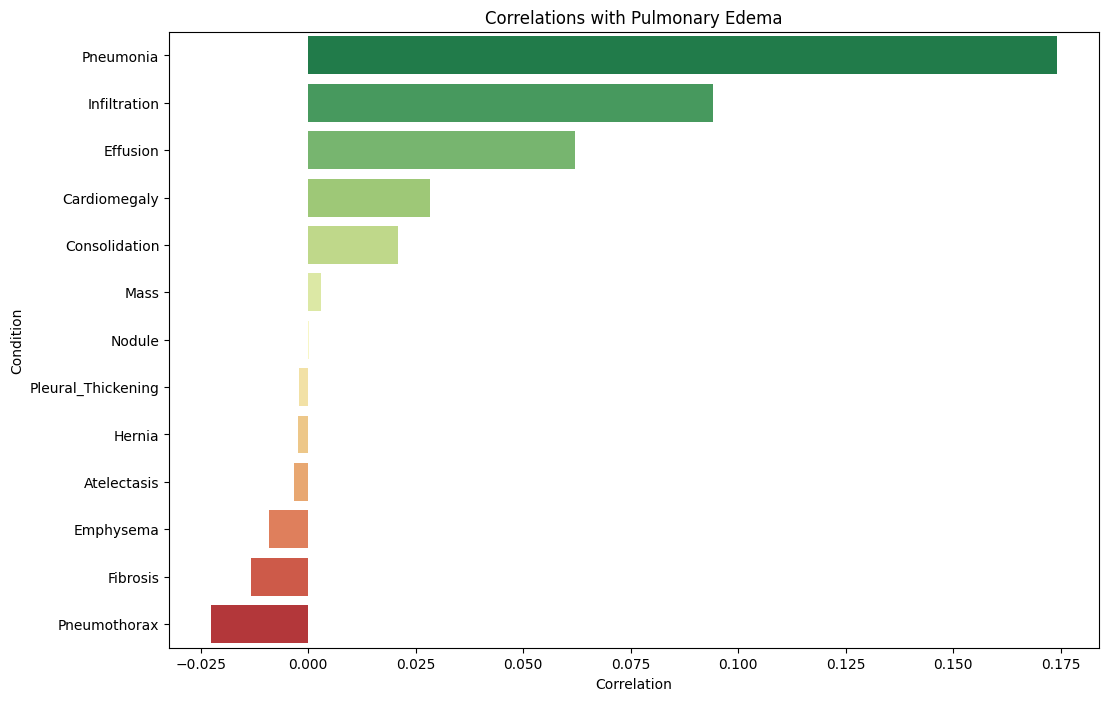

In [3]:
# Calculate correlations for Pneumonia and Edema
correlations_pneumonia = {label: correlation_matrix.at[label, 'Pneumonia'] for label in label_columns if 'Pneumonia' in label_columns}
correlations_edema = {label: correlation_matrix.at[label, 'Edema'] for label in label_columns if 'Edema' in label_columns}

# Visualize correlations with Pneumonia
correlation_df_pneumonia = pd.DataFrame.from_dict(correlations_pneumonia, orient='index', columns=['Correlation']).drop(['Pneumonia']).drop(['No Finding'])
correlation_df_pneumonia = correlation_df_pneumonia.reset_index().rename(columns={'index': 'Condition'})
correlation_df_pneumonia = correlation_df_pneumonia.sort_values(by='Correlation', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=correlation_df_pneumonia['Correlation'], y=correlation_df_pneumonia['Condition'], palette="RdYlGn_r")
plt.title("Correlations with Pneumonia")
plt.xlabel("Correlation")
plt.ylabel("Condition")
plt.show()

# Visualize correlations with Edema
correlation_df_edema = pd.DataFrame.from_dict(correlations_edema, orient='index', columns=['Correlation']).drop(['Edema']).drop(['No Finding'])
correlation_df_edema = correlation_df_edema.reset_index().rename(columns={'index': 'Condition'})
correlation_df_edema = correlation_df_edema.sort_values(by='Correlation', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=correlation_df_edema['Correlation'], y=correlation_df_edema['Condition'], palette="RdYlGn_r")
plt.title("Correlations with Pulmonary Edema")
plt.xlabel("Correlation")
plt.ylabel("Condition")
plt.show()

# Target labelling
Pour notre problème de différentiation entre l'oedème pulmonaire et les pneumonies, plusieurs approches peuvent être utilisés. 

Nous avons réfléchi notamment à utiliser une approche *un contre tous* où on entraîne 2 modèles à détecter chaque maladie, mais cela entraîne beaucoup de overload et de complexité dans l'application pratique.

La classification multiclasse est plus directe et nous semblait plus intéressante. 

Nous avons initialement séparé notre problème de classification en 5 classes :  "Pneumonia", "Edema", "Both", "Normal" and "Other", mais il y avait un trop gros débalancement pour que le modèle performe bien sur notre tâche initiale. Nous avons testé une fonction de perte *weighted*, un *undersampling* massif des catégories dominantes avec un oversampling des autres, mais même à cela des tests préliminaires donnait une sensibilité <50% pour toutes nos classes d'intérêts.

Nous avons donc opté pour une classification plus simple à 3 classes : "Pneumonia", "Edema" et "Both".

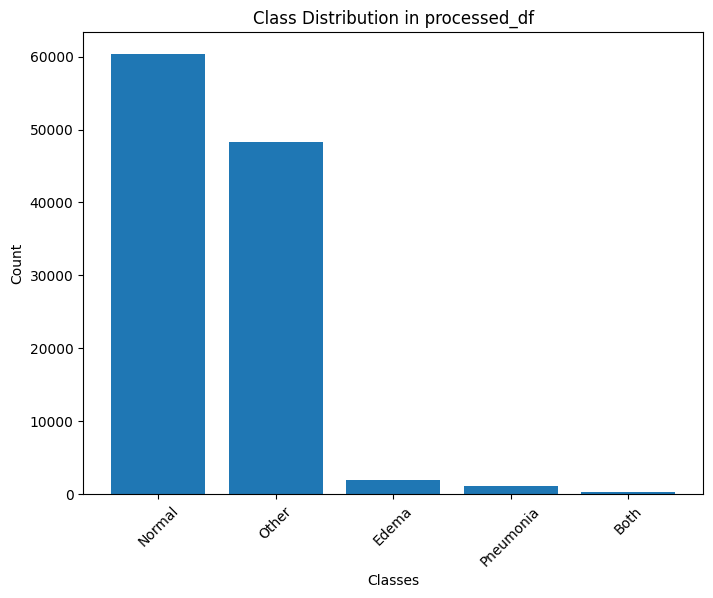

In [4]:
def processing(df, label_col, conditions, undersample_size=2000):
    """
    Categorizes labels, undersamples 'Normal' and 'Other' classes.
    """
    def categorize_label(label):
        if conditions[0] in label and conditions[1] in label:
            return "Both"
        elif conditions[0] in label:
            return "Pneumonia"
        elif conditions[1] in label:
            return "Edema"
        elif "No Finding" in label:
            return "Normal"
        else:
            return "Other"

    df["Target"] = df[label_col].apply(categorize_label)  
    return df

processed_df = processing(full_df, "Finding Labels", ["Pneumonia", "Edema"])
classes = processed_df["Target"].unique().tolist()

class_counts = processed_df["Target"].value_counts()

# Classes in final dataset
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Class Distribution in processed_df")
plt.xticks(rotation=45)  
plt.show()

## Séparation des groupes 

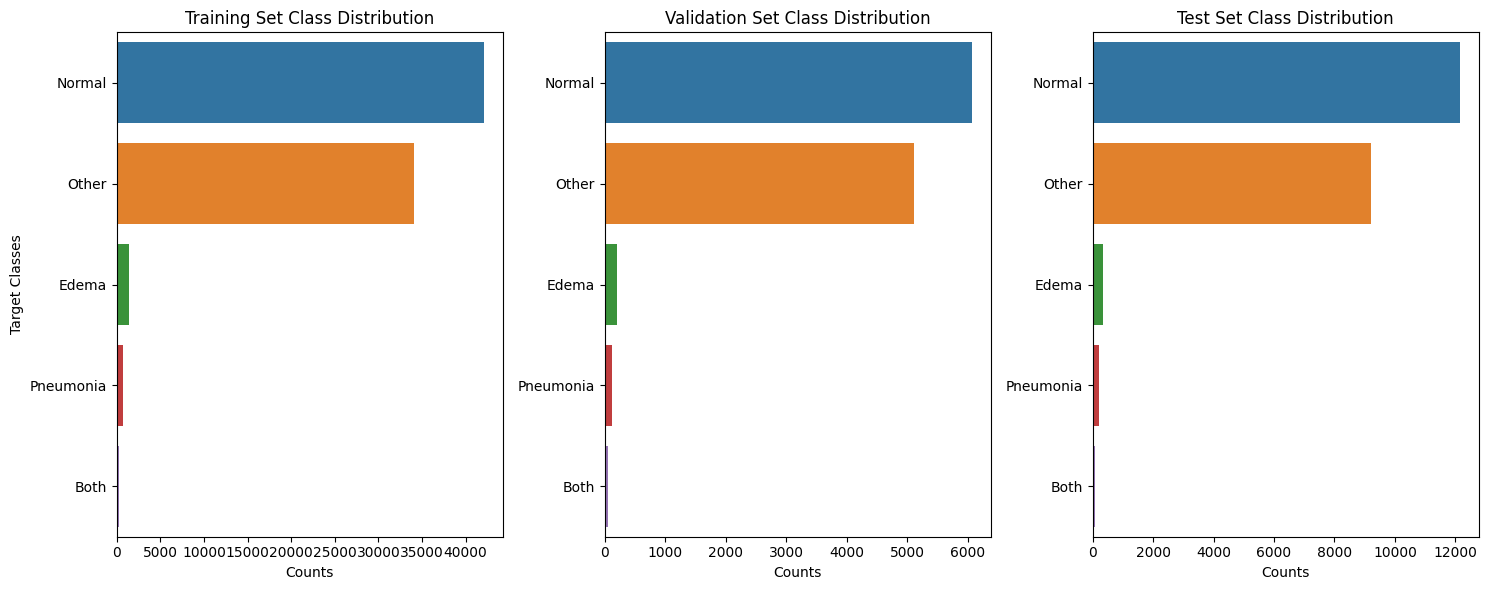

In [5]:
# Séparation des groupes basé sur l'identifiant patient pour éviter le "data leakage".
patient_col = "Patient ID"

test_size = 0.2
valid_size = 0.1

gss = GroupShuffleSplit(n_splits=1, test_size=test_size + valid_size, random_state=50)

# Séparation en donnée d'entraînement, de validation et de test
for train_idx, test_valid_idx in gss.split(processed_df, groups=processed_df[patient_col]):
    train_df = processed_df.iloc[train_idx]
    test_valid_df = processed_df.iloc[test_valid_idx]

gss_valid = GroupShuffleSplit(
    n_splits=1, test_size=test_size / (test_size + valid_size), random_state=42
)

for valid_idx, test_idx in gss_valid.split(
    test_valid_df, groups=test_valid_df[patient_col]
):
    valid_df = test_valid_df.iloc[valid_idx]
    test_df = test_valid_df.iloc[test_idx]
    
def plot_class_distributions(dataframes, titles):
    """
    Plots the class distributions of multiple DataFrames side by side.
    """
    plt.figure(figsize=(15, 6))

    num_dfs = len(dataframes)

    for i, df in enumerate(dataframes):
        plt.subplot(1, num_dfs, i+1)
        class_counts = df['Target'].value_counts()
        sns.barplot(x=class_counts.values, y=class_counts.index)
        plt.title(titles[i])
        plt.xlabel('Counts')
        if i == 0:
            plt.ylabel('Target Classes')
        else:
            plt.ylabel('')

    plt.tight_layout()
    plt.show()

plot_class_distributions(
    [train_df, valid_df, test_df], 
    ['Training Set Class Distribution', 'Validation Set Class Distribution', 'Test Set Class Distribution']
)


In [6]:
# Vu le débalancement extrême, on garde seulement un problème à 3 classes
train_df_disease = train_df[train_df['Target'].isin(["Edema", "Pneumonia", "Both"])]
val_df_disease = valid_df[valid_df['Target'].isin(["Edema", "Pneumonia", "Both"])]
test_df_disease = test_df[test_df['Target'].isin(["Edema", "Pneumonia", "Both"])]

### Visualisation des caractéristiques démographiques et cliniques

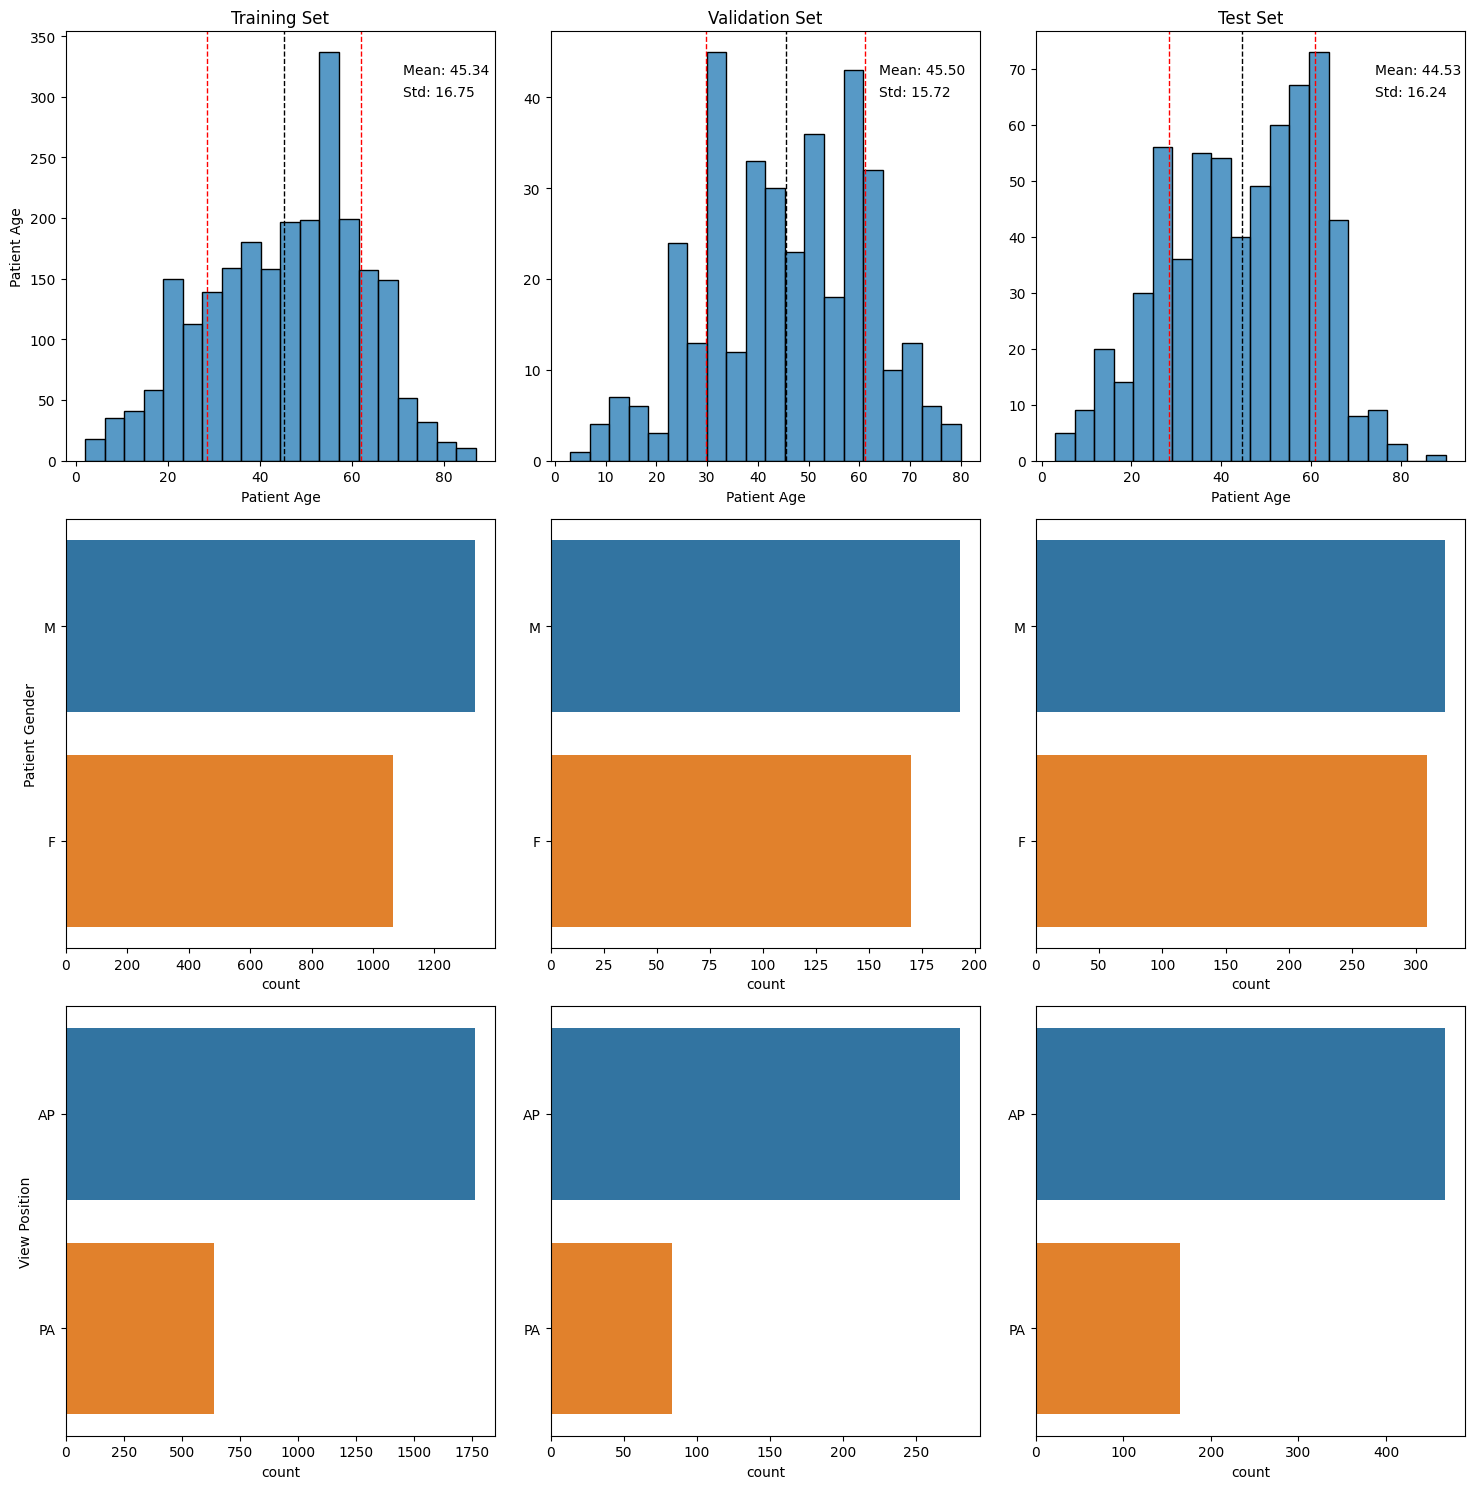

In [7]:
def plot_distributions(dataframes, titles, columns):
    """
    Plots the distributions of specified columns for multiple DataFrames.
    """
    num_dfs = len(dataframes)
    num_cols = len(columns)

    plt.figure(figsize=(15, 5 * num_cols))

    for i, df in enumerate(dataframes):
        for j, col in enumerate(columns):
            plt.subplot(num_cols, num_dfs, num_dfs * j + i + 1)
            if df[col].dtype == 'object':
                sns.countplot(y=df[col], order = df[col].value_counts().index)
            else:
                sns.histplot(df[col], bins=20, kde=False)
                mean_val = df[col].mean()
                std_val = df[col].std()
                plt.axvline(mean_val, color='k', linestyle='dashed', linewidth=1)
                plt.axvline(mean_val - std_val, color='r', linestyle='dashed', linewidth=1)
                plt.axvline(mean_val + std_val, color='r', linestyle='dashed', linewidth=1)
                min_ylim, max_ylim = plt.ylim()
                min_xlim, max_xlim = plt.xlim()
                plt.text(max_xlim-20, max_ylim*0.9, 'Mean: {:.2f}'.format(mean_val))
                plt.text(max_xlim-20, max_ylim*0.85, 'Std: {:.2f}'.format(std_val))
            
            if j == 0:
                plt.title(titles[i])
            
            if i == 0:
                plt.ylabel(col)
            else:
                plt.ylabel('')

    plt.tight_layout()
    plt.show()

columns_to_plot = ['Patient Age', 'Patient Gender', 'View Position']

plot_distributions(
    [train_df_disease, val_df_disease, test_df_disease], 
    ['Training Set', 'Validation Set', 'Test Set'],
    columns_to_plot
)

### Rebalancement des classes

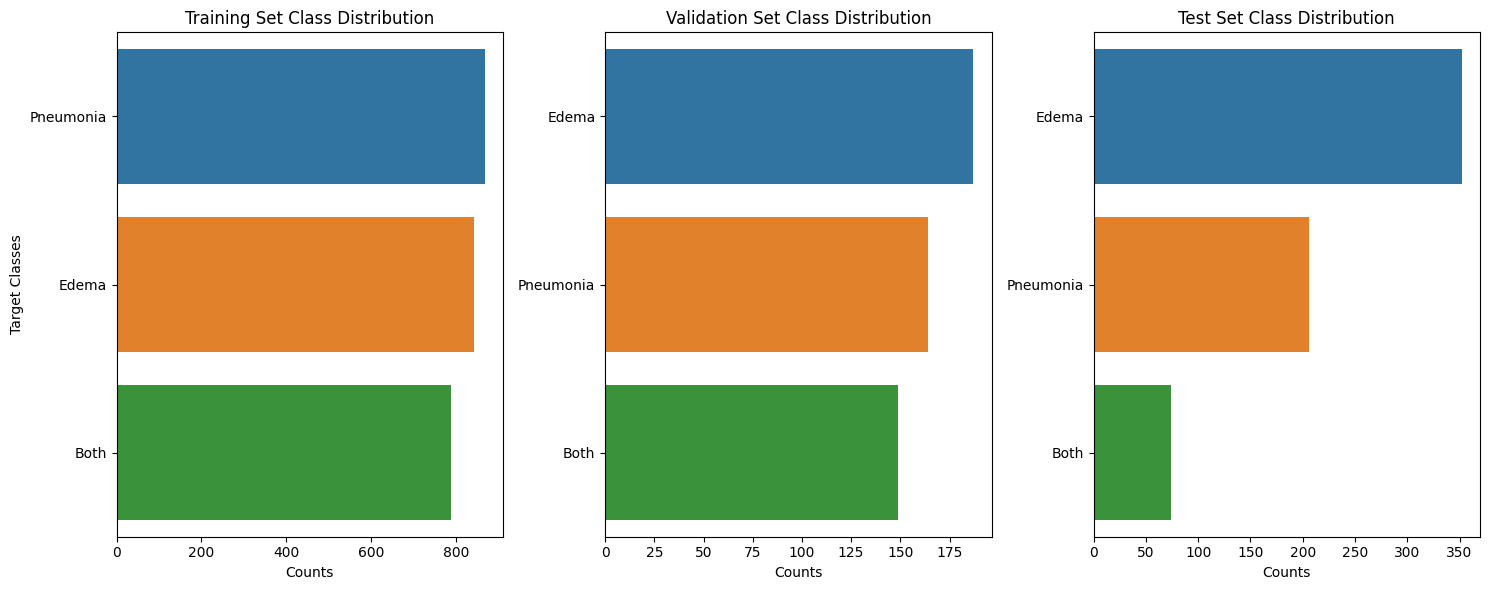

In [8]:
def create_inverse_weighted_sample(df, target_column, sample_size):
    # Calculate class weights (inverse of class frequencies)
    class_counts = df[target_column].value_counts()
    total_samples = df.shape[0]
    class_weights = {cls: total_samples/count for cls, count in class_counts.items()}

    # Assign a weight to each row in the DataFrame
    weights = df[target_column].map(class_weights)

    # Perform weighted random sampling
    return df.sample(n=sample_size, weights=weights, replace=True)

equalized_train_df_disease = create_inverse_weighted_sample(train_df_disease, 'Target', sample_size=2500)
equalized_val_df_disease = create_inverse_weighted_sample(train_df_disease, 'Target', sample_size=500)

plot_class_distributions(
    [equalized_train_df_disease, equalized_val_df_disease, test_df_disease], 
    ['Training Set Class Distribution', 'Validation Set Class Distribution', 'Test Set Class Distribution'])

In [9]:
base_image_dir = "/kaggle/input/data"

# Build the dictionary
image_folder_path = {
    os.path.basename(x): x
    for x in glob(os.path.join(base_image_dir, "images*", "images", "*.png"))
}

# Define a function to load and transform images
def load_transform_image(image_path, transform):
    image = Image.open(image_path)
    image = transform(image)
    return image

# Define a function to save images and labels to a Parquet file
def save_images_to_parquet(dataset, filename):
    table = pa.Table.from_pandas(dataset)
    pq.write_table(table, filename)
    
# Define the transforms for each dataset
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.RandomResizedCrop((224, 224)),  
    transforms.RandomRotation(5),  
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor()
])    
    
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
])

# Function to process and save dataset
def process_and_save_dataset(df, image_paths_dict, transform, filename1, filename2):
    images = []
    labels = []
    
    for _, row in df.iterrows():
        img_path = image_paths_dict.get(row['Image Index'])
        if img_path:
            image = load_transform_image(img_path, transform)
            image_np = np.array(image).flatten()/255 #Scale 0-1
            images.append(image_np)
            labels.append(row['Target'])
           
    images = pd.DataFrame({
        'images': images })
    labels = pd.DataFrame({
        'Target': labels })
        
    save_images_to_parquet(images, filename1)
    save_images_to_parquet(labels, filename2)

# Visualisation de radiographies pulmonaires après transformation

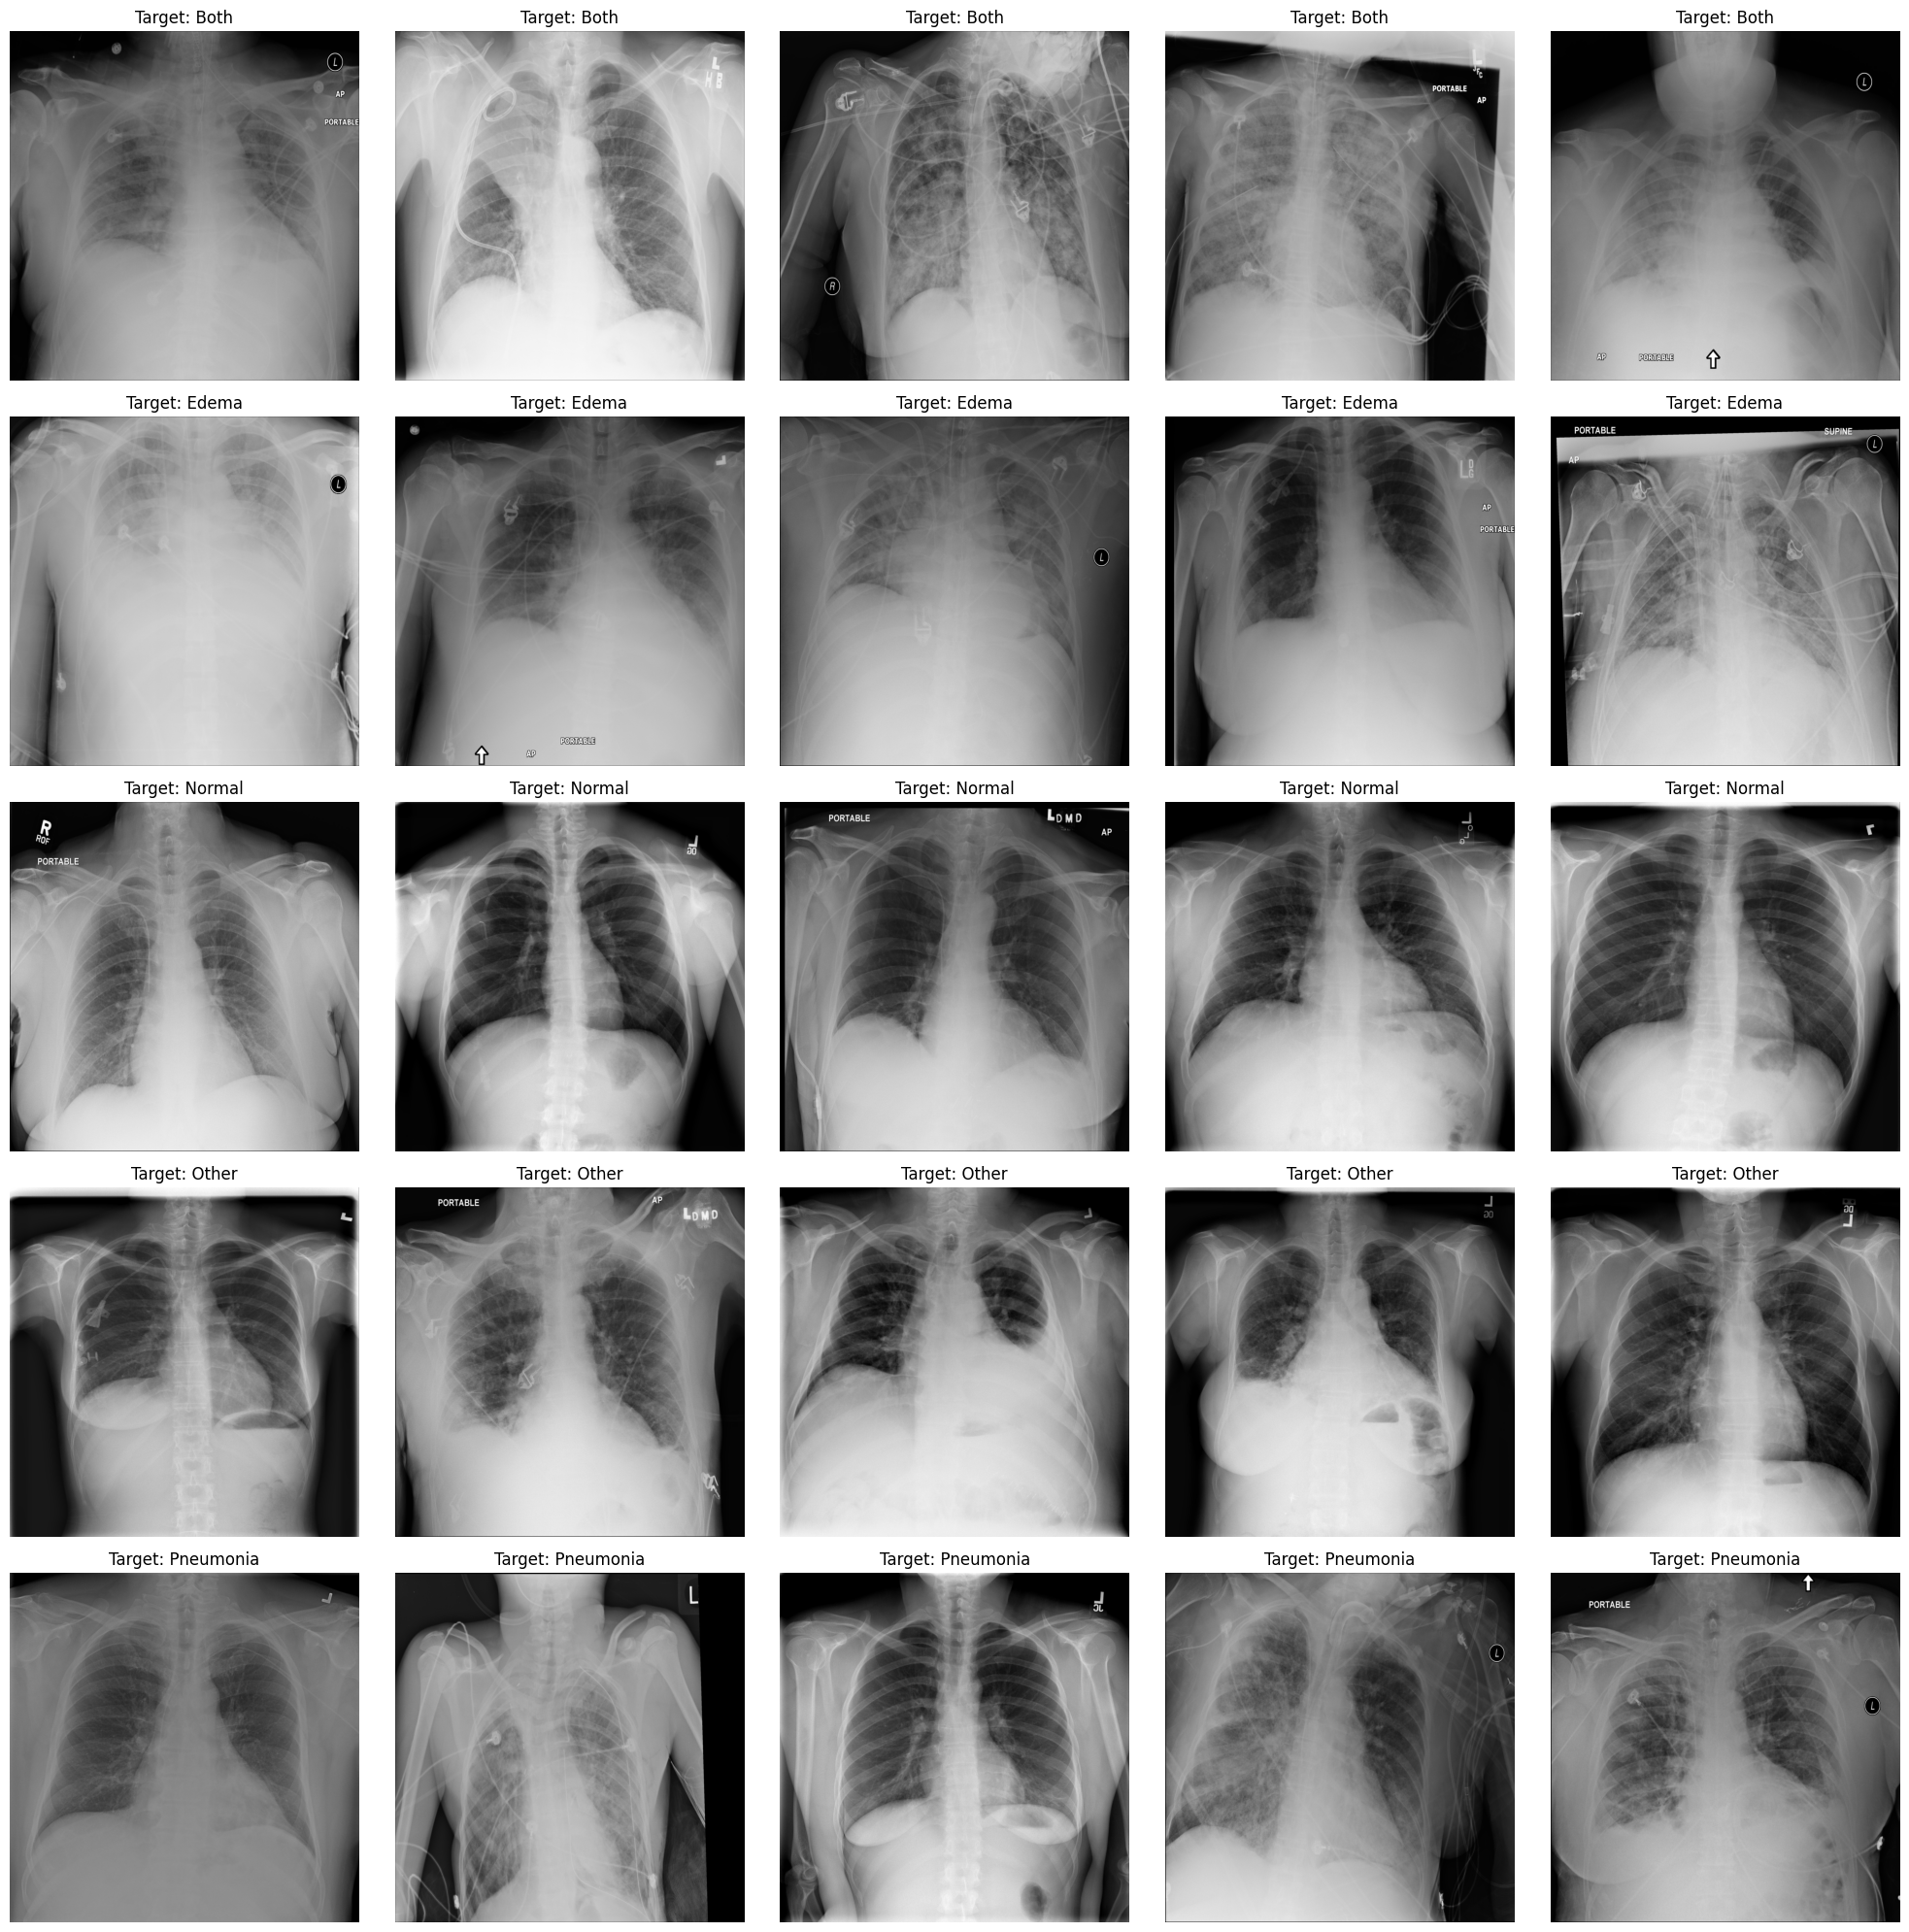

In [10]:
def plot_images(df, image_paths_dict, figsize=(20, 20)):

    grouped = df.groupby('Target')
    fig, axs = plt.subplots(len(grouped), 5, figsize=figsize) 

    for i, (target, group) in enumerate(grouped):
        random_samples = group.sample(n=5, replace=False)  
        for j in range(5):
            img_name = random_samples.iloc[j]['Image Index']
            img_path = image_paths_dict.get(img_name)
            if img_path:
                image = Image.open(img_path).convert("RGB")
                image = np.asarray(image)
                axs[i, j].imshow(image)
                axs[i, j].set_title(f"Target: {target}")
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

plot_images(processed_df, image_folder_path)

In [11]:
# Show characteristics of images before saving, used to ensure we have the correct shape as input
image_np = load_transform_image("/kaggle/input/data/images_001/images/00000001_000.png", val_test_transform)  

image_shape = image_np.shape  
image_dtype = image_np.dtype  

print("Image Shape:", image_shape)
print("Data Type:", image_dtype)

Image Shape: torch.Size([1, 224, 224])
Data Type: torch.float32


## Extraction des données sous format tabulaire en parquet.
Le jeu de données pré-séparé et transformé est enregistré sous 6 fichiers parquet.
X_train, y_train, X_val, y_val, X_test et y_test.

Chaque rangée des jeux de données X correspond à une image qui a été transformé, réduite en 224x224 (format communément utilisé en processing d'images) et aplatie en une seule rangée de 50 176 valeurs donnée sous forme de liste.

In [12]:
process_and_save_dataset(equalized_train_df_disease, image_folder_path, train_transform, "X_train.parquet", "y_train.parquet")
process_and_save_dataset(equalized_val_df_disease, image_folder_path, val_test_transform, "X_val.parquet", "y_val.parquet")
process_and_save_dataset(test_df_disease, image_folder_path, val_test_transform, "X_test.parquet", "y_test.parquet")